In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from src.dataset import load_team_data, load_agg_player_data
from src.preprocessing import impute_missing_values, split_data, remove_name_columns, encode_target_variable, remove_na_columns, find_knee_point

team_statistics, y = load_team_data()
player_statistics = load_agg_player_data()
x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

x = remove_name_columns(x)
y = encode_target_variable(y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

x_train, imputer, numeric_columns = impute_missing_values(x_train)
x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=numeric_columns)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=numeric_columns)

x_train, non_na_columns = remove_na_columns(x_train)
x_val, _ = remove_na_columns(x_val, non_na_columns=non_na_columns)
x_test, _ = remove_na_columns(x_test, non_na_columns=non_na_columns)

y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [4]:
# x_train_clean = x_train.copy()
# x_val_clean = x_val.copy()
# x_test_clean = x_test.copy()

In [113]:
x_train = x_train_clean.copy()
x_val = x_val_clean.copy()
x_test = x_test_clean.copy()

In [114]:
# === Load mutual information feature ===
scores = np.load("features_importance_mutual_info_based.npy")

order = np.argsort(scores)[::-1]
scores_sorted = scores[order]

k = 10
knee_indices = [find_knee_point(scores_sorted)]

for i in range(k-1):
    knee_indices.append(find_knee_point(scores_sorted[knee_indices[i]:]) + knee_indices[i])
# =======================================
    
# === Extract best features ===
index_knee = 8
columns_selected = x_train.columns[order[:knee_indices[index_knee]]]

features = list(columns_selected)
features = set([feature[5:] for feature in features])

columns_to_keep = ["HOME_" + feature for feature in features] + ["AWAY_" + feature for feature in features]

x_train = x_train[columns_to_keep]
x_val = x_val[columns_to_keep]
x_test = x_test[columns_to_keep]
# =============================

In [115]:
import torch

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.norm = torch.nn.LayerNorm(hidden_dim)
        self.act = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy()).float()
        self.y = torch.tensor(y).long()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [116]:
train_ds = Dataset(x_train, y_train)
val_ds = Dataset(x_val, y_val)
test_ds = Dataset(x_test, y_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
mlp = MLP(input_dim=x_train.shape[1], hidden_dim=8, output_dim=3).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=0.001, weight_decay=0.01)

n_epochs = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0)
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_model = None
best_val_acc = 0

for epoch in range(n_epochs):
    mlp.train()
    train_loss = 0
    train_acc = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = mlp(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item()
    scheduler.step()
    train_loss /= len(train_dl)
    train_acc /= len(x_train)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    mlp.eval()
    val_loss = 0
    val_acc = 0
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        y_pred = mlp(x)
        loss = criterion(y_pred, y)
        val_loss += loss.item()
        val_acc += (y_pred.argmax(dim=1) == y).sum().item()
    val_loss /= len(val_dl)
    val_acc /= len(x_val)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = mlp.state_dict()
    
    print(f"Epoch {epoch+1}/{n_epochs}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

Epoch 1/20, train_loss: 1.0693, val_loss: 1.0208, val_acc: 0.4972
Epoch 2/20, train_loss: 1.0477, val_loss: 1.0293, val_acc: 0.4876
Epoch 3/20, train_loss: 1.0469, val_loss: 1.0124, val_acc: 0.5018
Epoch 4/20, train_loss: 1.0395, val_loss: 1.0194, val_acc: 0.5028
Epoch 5/20, train_loss: 1.0317, val_loss: 1.0031, val_acc: 0.5084
Epoch 6/20, train_loss: 1.0362, val_loss: 1.0090, val_acc: 0.5038
Epoch 7/20, train_loss: 1.0330, val_loss: 1.0076, val_acc: 0.5099
Epoch 8/20, train_loss: 1.0338, val_loss: 1.0137, val_acc: 0.5053
Epoch 9/20, train_loss: 1.0220, val_loss: 1.0068, val_acc: 0.5048
Epoch 10/20, train_loss: 1.0251, val_loss: 1.0048, val_acc: 0.5074
Epoch 11/20, train_loss: 1.0252, val_loss: 1.0063, val_acc: 0.5043
Epoch 12/20, train_loss: 1.0188, val_loss: 1.0015, val_acc: 0.5074
Epoch 13/20, train_loss: 1.0221, val_loss: 1.0056, val_acc: 0.5048
Epoch 14/20, train_loss: 1.0194, val_loss: 1.0006, val_acc: 0.5053
Epoch 15/20, train_loss: 1.0178, val_loss: 1.0010, val_acc: 0.5063
Epoc

In [119]:
from sklearn.metrics import accuracy_score

mlp.load_state_dict(best_model)

mlp.eval()
y_pred = []
for x, y in train_dl:
    x, y = x.to(device), y.to(device)
    y_pred.append(torch.argmax(mlp(x), dim=1).cpu().numpy())

y_pred = np.concatenate(y_pred)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train accuracy: {accuracy:.4f}")

y_pred = []
for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    y_pred.append(torch.argmax(mlp(x), dim=1).cpu().numpy())

y_pred = np.concatenate(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

y_pred = []
for x, y in val_dl:
    x, y = x.to(device), y.to(device)
    y_pred.append(torch.argmax(mlp(x), dim=1).cpu().numpy())

y_pred = np.concatenate(y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f"Val accuracy: {accuracy:.4f}")

Train accuracy: 0.3898
Test accuracy: 0.5006
Val accuracy: 0.5058


In [111]:
y_pred = mlp(torch.tensor(x_val.to_numpy()).float().to(device))

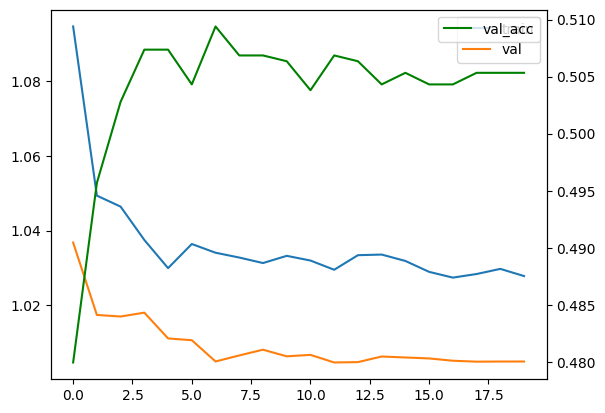

In [101]:
fig, ax = plt.subplots()

ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
plt.legend()

ax2 = ax.twinx()
ax2.plot(val_accs, label="val_acc", color='green')
plt.legend()
plt.show()

In [104]:
from src.postprocessing import compute_prediction, save_predictions

team_statistics = load_team_data(train=False)
player_statistics = load_agg_player_data(train=False)

x_test = pd.concat([team_statistics, player_statistics], axis=1, join='inner')
x_test = remove_name_columns(x_test)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=numeric_columns)
x_test, _ = remove_na_columns(x_test, non_na_columns=non_na_columns)

x_test = x_test[columns_to_keep]

x_test_tensor = torch.tensor(x_test.to_numpy()).float().to(device)
y_pred = torch.argmax(mlp(x_test_tensor), dim=1).cpu().numpy()
predictions = compute_prediction(y_pred, x_test)

save_predictions(predictions, "mlp.csv")

In [107]:
y_val_draw_mask = y_val == 1

x_val_draw = x_val[y_val_draw_mask]

x_val_draw_tensor = torch.tensor(x_val_draw.to_numpy()).float().to(device)
y = torch.functional.F.softmax(mlp(x_val_draw_tensor), dim=1).cpu().detach().numpy()